In [3]:
import pandas as pd
import matplotlib as mpl
from mpl_toolkits import mplot3d
mpl.rcParams['agg.path.chunksize'] = 10000
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import random
from river import drift
import os
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import scipy

(10.0, 14.0, 0.0, 160.0)

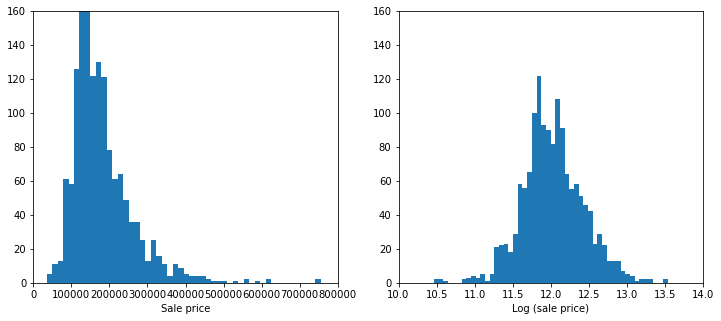

In [4]:
file_path = "Housing"
test_params = {'max_depth':[4,8,12], 'learning_rate': [0.1, 0.01, 0.05]}
df = pd.read_csv(os.path.join(file_path, "train.csv"))
import matplotlib.pyplot as plt
# Set up the matplotlib figure
plt.figure(figsize=(12,5))
#f, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
plt.subplot(121)
plt.hist(df['SalePrice'],bins=50)
plt.xlabel('Sale price')
plt.axis([0,800000,0,160])
plt.subplot(122)
plt.hist(np.log(df['SalePrice']),bins=50)
plt.xlabel('Log (sale price)')
plt.axis([10,14,0,160])

In [5]:
random.seed(42)
df = df[df["BldgType"].str.contains("1Fam")]
df = df[df["SaleCondition"].str.contains("Normal")]
df["SinceBuilt"] = df["YrSold"] - df["YearBuilt"]
min_year = df["YrSold"].min()
max_year = df["YrSold"].max()
X = df[["LotFrontage", "LotArea", "OverallQual", "OverallCond", "TotalBsmtSF", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "SinceBuilt", "YrSold"]]
y = df[["SalePrice", "YrSold"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42)
all_error_indist = np.empty(1,)
all_error_outdist = np.empty(1,)
for i in range(min_year, max_year):
    print("Train Year: ", i, ", Test Year: ", i+1)
    X_train_indist = X_train[X_train["YrSold"] == i]
    X_train_outdist = X_train[X_train["YrSold"] == i+1]
    #X_train_outdist = X_train[X_train["YrSold"] > i]
    y_train_indist = np.log1p(y_train[y_train["YrSold"] == i].drop("YrSold",axis=1))
    y_train_outdist = np.log1p(y_train[y_train["YrSold"] == i+1].drop("YrSold",axis=1))
    #y_train_outdist = np.log1p(y_train[y_train["YrSold"] > i].drop("YrSold",axis=1))
    
    X_test_indist = X_test[X_test["YrSold"] == i]
    X_test_outdist = X_test[X_test["YrSold"] == i+1]
    #X_test_outdist = X_test[X_test["YrSold"] > i]
    y_test_indist = np.log1p(y_test[y_test["YrSold"] == i].drop("YrSold",axis=1))
    y_test_outdist = np.log1p(y_test[y_test["YrSold"] == i+1].drop("YrSold",axis=1))
    #y_test_outdist = np.log1p(y_test[y_test["YrSold"] > i].drop("YrSold",axis=1))
    
    xgbr = xgb.XGBRegressor(random_state=42)
    model = GridSearchCV(estimator = xgbr,param_grid = test_params,verbose=False)
    model.fit(X_train_indist, y_train_indist)
    
    preds_indist = model.predict(X_test_indist)
    error_indist = np.subtract(preds_indist, y_test_indist["SalePrice"])
    rmse_indist = sqrt(mean_squared_error(y_test_indist, preds_indist))
    all_error_indist = np.append(all_error_indist, error_indist)
    
    X_outdist = pd.concat([X_train_outdist, X_test_outdist])
    y_outdist = np.transpose(np.array(pd.concat([y_train_outdist, y_test_outdist])))[0]
    preds_outdist = model.predict(X_outdist)
    error_outdist = np.subtract(preds_outdist, y_outdist)
    rmse_outdist = sqrt(mean_squared_error(y_outdist, preds_outdist))
    all_error_outdist = np.append(all_error_outdist, error_outdist)
    
    ks_pval = scipy.stats.kstest(error_outdist, error_indist, alternative='two-sided', method='auto')[1]
    print("RMSE Indist", rmse_indist)
    print("RMSE Outdist", rmse_outdist)
    print("K-S p-value", ks_pval, "\n")
print("Done")

Train Year:  2006 , Test Year:  2007
RMSE Indist 0.13284268581345732
RMSE Outdist 0.157453733226291
K-S p-value 0.6987459626706295 

Train Year:  2007 , Test Year:  2008
RMSE Indist 0.17708221268834323
RMSE Outdist 0.17707739271546905
K-S p-value 0.9437282480910046 

Train Year:  2008 , Test Year:  2009
RMSE Indist 0.15913638722025267
RMSE Outdist 0.17231120846014436
K-S p-value 0.5925687807855744 

Train Year:  2009 , Test Year:  2010
RMSE Indist 0.15343528048525917
RMSE Outdist 0.1405954894161311
K-S p-value 0.796155631657247 

Done


In [ ]:
random.seed(42)
file_path = "Housing"
test_params = {'max_depth':[4,8,12], 'learning_rate': [0.1, 0.01, 0.05]}
df = pd.read_csv(os.path.join(file_path, "train.csv"))
df = df[df["BldgType"].str.contains("1Fam")]
df = df[df["SaleCondition"].str.contains("Normal")]
df["SinceBuilt"] = df["YrSold"] - df["YearBuilt"]
min_year = df["YrSold"].min()
max_year = df["YrSold"].max()
X = df[["LotFrontage", "LotArea", "OverallQual", "OverallCond", "TotalBsmtSF", "FullBath", "HalfBath", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "SinceBuilt", "YrSold"]]
y = df[["SalePrice", "YrSold"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33,random_state=42)
all_error_indist = np.empty(1,)
all_error_outdist = np.empty(1,)
X_train_indist = X_train[X_train["YrSold"] < 2008]
X_train_outdist = X_train[X_train["YrSold"] > 2008]
y_train_indist = np.log1p(y_train[y_train["YrSold"] < 2008].drop("YrSold",axis=1))
y_train_outdist = np.log1p(y_train[y_train["YrSold"] > 2008].drop("YrSold",axis=1))

X_test_indist = X_test[X_test["YrSold"] < 2008]
X_test_outdist = X_test[X_test["YrSold"] > 2008]
y_test_indist = np.log1p(y_test[y_test["YrSold"] < 2008].drop("YrSold",axis=1))
y_test_outdist = np.log1p(y_test[y_test["YrSold"] > 2008].drop("YrSold",axis=1))

xgbr = xgb.XGBRegressor(random_state=42)
model = GridSearchCV(estimator = xgbr,param_grid = test_params,verbose=True)
model.fit(X_train_indist, y_train_indist)

preds_indist = model.predict(X_test_indist)
error_indist = np.subtract(y_test_indist["SalePrice"], preds_indist)
rmse_indist = sqrt(mean_squared_error(y_test_indist, preds_indist))
all_error_indist = np.append(all_error_indist, error_indist)

X_outdist = pd.concat([X_train_outdist, X_test_outdist])
y_outdist = np.transpose(np.array(pd.concat([y_train_outdist, y_test_outdist])))[0]
preds_outdist = model.predict(X_outdist)
error_outdist = np.subtract(y_outdist, preds_outdist)
rmse_outdist = sqrt(mean_squared_error(y_outdist, preds_outdist))
all_error_outdist = np.append(all_error_outdist, error_outdist)

ks_pval = scipy.stats.kstest(error_outdist, error_indist, alternative='two-sided', method='auto')[1]
print("RMSE Indist", rmse_indist)
print("RMSE Outdist", rmse_outdist)
print("K-S p-value", ks_pval)
print("Done")

In [ ]:
import random
import numpy
from matplotlib import pyplot


bins = numpy.linspace(-1, 1, 50)

pyplot.hist(all_error_indist, bins, density=True, alpha=0.5, label='indist')
pyplot.hist(all_error_outdist, bins, density=True, alpha=0.5, label='outdist')
pyplot.legend(loc='upper right')
plt.xlabel("Residuals (Actual - Predicted)")
plt.ylabel("Density")
pyplot.show()